In [1]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
from scipy.optimize import linear_sum_assignment

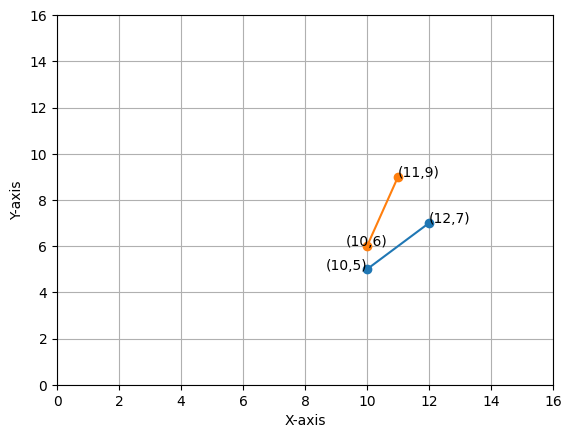

In [2]:
# Define points
x = [10, 12]
y = [5, 7]

x1 = [10, 11]
y1 = [6, 9]

# Plot the points
plt.plot(x, y, marker='o')

plt.plot(x1, y1, marker='o')

# Label the points
plt.text(11,9, '(11,9)', ha='left')
plt.text(10, 6, '(10,6)', ha='center')
plt.text(10, 5, '(10,5)', ha='right')
plt.text(12, 7, '(12,7)', ha='left')

# Set the limits of the Cartesian plane
plt.xlim(0, 16)
plt.ylim(0, 16)

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add grid
plt.grid(True)

# Set equal

**Question :**
**Given two previous coordinates, id1(10,5) and id2(10,6), how can an algorithm assign IDs to the current coordinates, (12,7) and (11,9)? Explain how the algorithm would determine the assignments using criteria like directionality and IoU, and provide the underlying theory.**

Let’s walk through a concrete toy example so you can see how the two-cue fusion (IoU + direction) drives the correct matching.

1.  **Setup**

    * **Previous tracks:**
        * Track 1 (ID 1) last box centroid $\mathbf{c}_{1,t-1} = (10, 5)$
        * Track 2 (ID 2) last box centroid $\mathbf{c}_{2,t-1} = (10, 6)$
        * For direction, we need one earlier centroid as well:
            * Track 1 at $t-2$: $\mathbf{c}_{1,t-2} = (9, 4)$
            * Track 2 at $t-2$: $\mathbf{c}_{2,t-2} = (10, 4)$
    * **Current detections:**
        * Det A at $\mathbf{c}_A = (12, 7)$
        * Det B at $\mathbf{c}_B = (11, 9)$

2.  **Compute each track’s previous direction**

    * **Track 1:**
        $$\Delta\mathbf{c}_1^{\text{prev}} = \mathbf{c}_{1,t-1} - \mathbf{c}_{1,t-2} = (10, 5) - (9, 4) = (1, 1)$$
        $$\mathbf{d}_1 = \frac{(1, 1)}{\sqrt{1^2 + 1^2}} = \left(\frac{1}{\sqrt{2}}, \frac{1}{\sqrt{2}}\right)$$
    * **Track 2:**
        $$\Delta\mathbf{c}_2^{\text{prev}} = \mathbf{c}_{2,t-1} - \mathbf{c}_{2,t-2} = (10, 6) - (10, 4) = (0, 2)$$
        $$\mathbf{d}_2 = \frac{(0, 2)}{\sqrt{0^2 + 2^2}} = (0, 1)$$

3.  **For each (track, detection) pair, compute:**

    * **a) Distance gating**
        Choose a max pixel jump, e.g., $D_{\max} = 5$.

        * $\|\mathbf{c}_A - \mathbf{c}_{1,t-1}\| = \|(12, 7) - (10, 5)\| = \sqrt{2^2 + 2^2} = 2.8 < 5 \implies$ allowed
        * $\|\mathbf{c}_B - \mathbf{c}_{1,t-1}\| = \|(11, 9) - (10, 5)\| = \sqrt{1^2 + 4^2} = 4.1 < 5 \implies$ allowed
        * $\|\mathbf{c}_A - \mathbf{c}_{2,t-1}\| = \|(12, 7) - (10, 6)\| = \sqrt{2^2 + 1^2} = 2.2 < 5 \implies$ allowed
        * $\|\mathbf{c}_B - \mathbf{c}_{2,t-1}\| = \|(11, 9) - (10, 6)\| = \sqrt{1^2 + 3^2} = 3.2 < 5 \implies$ allowed

    * **b) Direction score**
        Compute the implied direction from each track into each detection, then the cosine similarity with the track’s stored $\mathbf{d}$.

        * **Track 1 → Det A:**
            $$\Delta = (12, 7) - (10, 5) = (2, 2), \quad \mathbf{u} = \frac{(2, 2)}{\sqrt{2^2 + 2^2}} = \left(\frac{1}{\sqrt{2}}, \frac{1}{\sqrt{2}}\right)$$
            $$s_{\text{dir}}^{(1,A)} = \mathbf{d}_1 \cdot \mathbf{u} = \frac{1}{\sqrt{2}} \times \frac{1}{\sqrt{2}} + \frac{1}{\sqrt{2}} \times \frac{1}{\sqrt{2}} = 1.0$$
        * **Track 1 → Det B:**
            $$\Delta = (11, 9) - (10, 5) = (1, 4), \quad \|\Delta\| \approx 4.12, \quad \mathbf{u} \approx (0.24, 0.97)$$
            $$s_{\text{dir}}^{(1,B)} = \frac{1}{\sqrt{2}} \times 0.24 + \frac{1}{\sqrt{2}} \times 0.97 \approx 0.85$$
        * **Track 2 → Det A:**
            $$\Delta = (12, 7) - (10, 6) = (2, 1), \quad \|\Delta\| \approx 2.24, \quad \mathbf{u} \approx (0.89, 0.45)$$
            $$s_{\text{dir}}^{(2,A)} = (0, 1) \cdot (0.89, 0.45) = 0.45$$
        * **Track 2 → Det B:**
            $$\Delta = (11, 9) - (10, 6) = (1, 3), \quad \|\Delta\| \approx 3.16, \quad \mathbf{u} \approx (0.32, 0.95)$$
            $$s_{\text{dir}}^{(2,B)} = (0, 1) \cdot (0.32, 0.95) = 0.95$$

    * **c) IoU score**
        If your boxes are all the same size, or you only care about centroid distance, you can approximate $s_{\text{IoU}}$ equally for all valid pairs. In a real tracker, you’d compute true box overlap—let’s assume:
        $$s_{\text{IoU}}^{(i,j)} = 0.8 \quad \text{for every valid pair.}$$

4.  **Fuse scores & solve**

    With equal weights:
    $$\text{score}_{ij} = 0.5 \, s_{\text{IoU}}^{(i,j)} + 0.5 \, s_{\text{dir}}^{(i,j)}.$$
    This gives:

    | Pairs     | $s_{\text{IoU}}$ | $s_{\text{dir}}$ | score | cost = 1 – score |
    | :-------- | :--------------- | :--------------- | :---- | :--------------- |
    | 1 → A     | 0.8              | 1.0              | 0.90  | 0.10             |
    | 1 → B     | 0.8              | 0.85             | 0.825 | 0.175            |
    | 2 → A     | 0.8              | 0.45             | 0.625 | 0.375            |
    | 2 → B     | 0.8              | 0.95             | 0.875 | 0.125            |

    Running the Hungarian algorithm on this 2x2 cost matrix picks the minimal-total-cost pairing:

    Track 1 ↔ Det A (cost 0.10)
    Track 2 ↔ Det B (cost 0.125)

5.  **Why it “just works”**

    * Direction tells you that Det A continues exactly along Track 1’s NE heading, whereas Det B is slightly off that heading.
    * Direction also tells you that Det B best continues Track 2’s northward motion, whereas Det A would require Track 2 to veer east.
    * IoU (or any overlap/distance cue) is equal, so it can’t override a strong directional mismatch.
    * Together, the algorithm correctly assigns ID 1 → (12, 7), ID 2 → (11, 9).

In [ ]:
def compute_iou(box, boxes):
    if box is None or len(box) != 4 or len(boxes) == 0:
        return None, None

    box = np.array(box)
    boxes = np.array(boxes)

    x1 = np.maximum(box[0], boxes[:, 0])
    y1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[2], boxes[:, 2])
    y2 = np.minimum(box[3], boxes[:, 3])

    inter_w = np.maximum(0, x2 - x1)
    inter_h = np.maximum(0, y2 - y1)
    inter_area = inter_w * inter_h

    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union_area = box_area + boxes_area - inter_area

    ious = inter_area / np.maximum(union_area, 1e-6)

    max_iou = np.max(ious)
    best_match_idx = np.argmax(ious)

    return max_iou, best_match_idx

# You need to maintain these globals in your module:
#   tracked_objects: {track_id: [x1,y1,x2,y2], …}
#   last_seen:       {track_id: last_frame_count, …}
#   next_id:         integer
#   dwell_time_start:{track_id: frame_count, …}
# And add:
#   centroids:       {track_id: np.array([cx,cy]), …}
#   directions:      {track_id: np.array([dx,dy]), …}  # unit-vectors

def compute_centroid(box):
    x1,y1,x2,y2 = box
    return np.array([(x1+x2)/2, (y1+y2)/2])

def unit_vector(v, eps=1e-6):
    norm = np.linalg.norm(v)
    return v/norm if norm>eps else None

def fun_track_id(boxes, frame_count,
                 iou_threshold=0.2,
                 max_dist=100,       # distance gating radius in px
                 expire_after=120,
                 BASE_IOU_W = 0.7, BASE_DIR_W = 0.3):
    
    global tracked_objects, next_id, last_seen, dwell_time_start
    global centroids, directions

    # 1. Purge stale tracks (same as before)
    stale = [tid for tid, last in last_seen.items()
             if frame_count - last > expire_after]
    for tid in stale:
        tracked_objects.pop(tid, None)
        last_seen.pop(tid, None)
        centroids.pop(tid, None)
        directions.pop(tid, None)

    prev_ids   = list(tracked_objects.keys())
    prev_boxes = [tracked_objects[tid] for tid in prev_ids]
    curr_boxes = list(boxes)
    curr_cents = [compute_centroid(b) for b in curr_boxes]

    P, C = len(prev_boxes), len(curr_boxes)
    assigned_prev = set()
    assigned_curr = set()
    new_assignments = {}

    if P>0 and C>0:
        # precompute prev centroids & directions
        prev_cents = np.array([centroids[tid] for tid in prev_ids])
        prev_dirs  = [directions.get(tid) for tid in prev_ids]

        iou_mat = np.zeros((P,C), dtype=np.float32)
        dir_mat = np.zeros((P,C), dtype=np.float32)
        cost_mat= np.ones ((P,C), dtype=np.float32)

        for i, p in enumerate(prev_boxes):
            p = np.array(p)
            cb = np.array(curr_boxes)
            # IoU
            x1 = np.maximum(p[0], cb[:,0]); y1 = np.maximum(p[1], cb[:,1])
            x2 = np.minimum(p[2], cb[:,2]); y2 = np.minimum(p[3], cb[:,3])
            inter = np.maximum(0, x2-x1)*np.maximum(0, y2-y1)
            area_p = (p[2]-p[0])*(p[3]-p[1])
            area_c = (cb[:,2]-cb[:,0])*(cb[:,3]-cb[:,1])
            union  = area_p + area_c - inter
            iou_mat[i] = inter/np.maximum(union,1e-6)

            # distance gating + direction
            for j, cc in enumerate(curr_cents):
                # 2.a Distance gating
                dist = np.linalg.norm(cc - prev_cents[i])
                if dist > max_dist:
                    continue  # cost stays at 1 → effectively forbidden

                # 2.b Direction score
                prev_dir = prev_dirs[i]
                delta    = cc - prev_cents[i]
                cand_dir = unit_vector(delta)
                if prev_dir is not None and cand_dir is not None:
                    dir_mat[i,j] = max(0.0, np.dot(prev_dir, cand_dir))
                # otherwise dir_mat[i,j] stays 0

                # 3. combined cost (equal weights)
                score = BASE_IOU_W * iou_mat[i,j] + BASE_DIR_W * dir_mat[i,j]
                cost_mat[i,j] = 1.0 - score

        # 4. Hungarian on fused cost
        row_ind, col_ind = linear_sum_assignment(cost_mat)

        # 5. accept only good matches
        for r,c in zip(row_ind, col_ind):
            if iou_mat[r,c] >= iou_threshold:
                pid = prev_ids[r]
                assigned_prev.add(pid)
                assigned_curr.add(c)
                new_assignments[pid] = curr_boxes[c]

    # 6. Update matched tracks
    for pid, box in new_assignments.items():
        tracked_objects[pid] = box
        last_seen[pid] = frame_count

        # update centroid & direction
        new_c = compute_centroid(box)
        old_c = centroids[pid]
        centroids[pid] = new_c
        delta = new_c - old_c
        u = unit_vector(delta)
        if u is not None:
            directions[pid] = u

    # 7. Spawn new IDs
    for idx, box in enumerate(curr_boxes):
        if idx in assigned_curr:
            continue
        pid = next_id
        tracked_objects[pid]    = box
        last_seen[pid]          = frame_count
        dwell_time_start[pid]   = frame_count
        centroids[pid]          = compute_centroid(box)
        directions[pid]         = None  # no direction yet
        next_id += 1

    # 8. Return current‐frame tracks
    return {
        tid: tracked_objects[tid]
        for tid, last in last_seen.items()
        if last == frame_count
    }

In [ ]:
# ─────────────── MAIN LOOP ───────────────
input_video = 'BT-OrderCounter-2.mp4'
output_video = None #'BT-OrderCounter-2 dwell time (new tracker).mp4'

cap = cv2.VideoCapture(input_video)
model = YOLO("yolo11m.pt").to('mps')

fps = int(cap.get(cv2.CAP_PROP_FPS))
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_skip = 3
frame_count = 0

diag = np.hypot(w, h)
max_dist = 0.1 * diag    # e.g. 10% of the diagonal

# Setup video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video, fourcc, fps // 2, (w, h))  # fps//2 because of frame_skip=30

tracked_objects = {}      # track_id → box
last_seen = {}            # track_id → last seen frame
dwell_time_start = {}     # track_id → first seen frame
next_id = 0

# new for direction & distance:
centroids  = {}           # track_id → last centroid (np.array)
directions = {}           # track_id → last unit‐vector (np.array) or None

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count % frame_skip != 0:
        continue

    result = model.predict(frame, verbose=False,iou=0.5)[0]
    boxes = result.boxes
    xyxy = boxes.xyxy.cpu().numpy()
    classes = boxes.cls.cpu().numpy()
    confs = boxes.conf.cpu().numpy()

    keep = (confs > 0.4) & (classes == 0)
    xyxy = xyxy[keep]

    tracked = fun_track_id(
        xyxy,
        frame_count,
        iou_threshold=0.2,
        max_dist=max_dist,
        expire_after=120
    )

    for track_id, box in tracked.items():
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Calculate dwell time
        start_frame = dwell_time_start.get(track_id, frame_count)
        dwell_frames = frame_count - start_frame
        dwell_seconds = dwell_frames // fps

        label = f'ID {track_id} | Dwell time ({dwell_seconds}s)'
        cv2.putText(frame, label, (x1, y2 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)

    # write and show frame
    out.write(frame)
    cv2.imshow("Tracked", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
 
cap.release()
out.release()
cv2.destroyAllWindows()

# ─────────────── FINAL DWELL REPORT ───────────────
print("\nFinal Dwell Times:")
for tid, start_frame in dwell_time_start.items():
    dwell_frames = frame_count - start_frame
    dwell_seconds = dwell_frames // fps
    print(f"Track ID {tid}: {dwell_seconds} seconds")

[ WARN:0@1.332] global cap.cpp:781 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/videoio/src/cap_images.cpp:209: error: (-215:Assertion failed) !filename.empty() in function 'icvExtractPattern'


2025-05-02 10:09:08.129 Python[46092:1129884] +[IMKClient subclass]: chose IMKClient_Modern
2025-05-02 10:09:08.129 Python[46092:1129884] +[IMKInputSession subclass]: chose IMKInputSession_Modern
